# Hi :)

----

# Import libraries

In [22]:
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Loading the dataset

In [2]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.cifar10.load_data()

# Step 1

selecting 10,000 data(1,000 for eace class)

In [3]:
x_data= np.concatenate((x_train, x_test), axis=0)
y_data= np.concatenate((y_train, y_test), axis=0)

num_per_class= 1000
num_classes= 10

selected_images= []
selected_labels= []

for class_id in range(num_classes):
    class_indices= np.where(y_data == class_id)[0]
    selected_indices= np.random.choice(class_indices, num_per_class, replace=False)
    selected_images.append(x_data[selected_indices])
    selected_labels.append(y_data[selected_indices])

selected_images= np.concatenate(selected_images, axis=0)
selected_labels= np.concatenate(selected_labels, axis=0)

print(f"Selected images shape: {selected_images.shape}")
print(f"Selected labels shape: {selected_labels.shape}")

Selected images shape: (10000, 32, 32, 3)
Selected labels shape: (10000, 1)


# Step 2

set the resolutions(32x32 and 16x16)

In [4]:
original_resolution= (32, 32)
low_resolution= (16, 16)

data_high_res= x_data.copy()

data_low_res= []
for img in x_data:
    low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)
    data_low_res.append(np.array(low_res_img))
data_low_res= np.array(data_low_res)

print(f"High-resolution data shape: {data_high_res.shape}")
print(f"Low-resolution data shape: {data_low_res.shape}")

C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_22432\3995905558.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  low_res_img= Image.fromarray(img).resize(low_resolution, Image.ANTIALIAS)


High-resolution data shape: (60000, 32, 32, 3)
Low-resolution data shape: (60000, 16, 16, 3)


# Step 3

spliting the dataset to train and test and validation

In [5]:
train_ratio= 0.7
val_ratio= 0.15
test_ratio= 0.15

num_samples= len(y_data)

indices= np.arange(num_samples)
np.random.shuffle(indices)

train_end= int(train_ratio * num_samples)
val_end= train_end + int(val_ratio * num_samples)

train_indices= indices[ : train_end]
val_indices= indices[train_end : val_end]
test_indices= indices[val_end : ]


x_train_high, x_val_high, x_test_high= data_high_res[train_indices], data_high_res[val_indices], data_high_res[test_indices]
x_train_low, x_val_low, x_test_low= data_low_res[train_indices], data_low_res[val_indices], data_low_res[test_indices]
y_train, y_val, y_test= y_data[train_indices], y_data[val_indices], y_data[test_indices]


print(f"High-Resolution Data Shapes: Train: {x_train_high.shape}, Validation: {x_val_high.shape}, Test: {x_test_high.shape}")
print(f"Low-Resolution Data Shapes: Train: {x_train_low.shape}, Validation: {x_val_low.shape}, Test: {x_test_low.shape}")
print(f"Labels Shapes: Train: {y_train.shape}, Validation: {y_val.shape}, Test: {y_test.shape}")

High-Resolution Data Shapes: Train: (42000, 32, 32, 3), Validation: (9000, 32, 32, 3), Test: (9000, 32, 32, 3)
Low-Resolution Data Shapes: Train: (42000, 16, 16, 3), Validation: (9000, 16, 16, 3), Test: (9000, 16, 16, 3)
Labels Shapes: Train: (42000, 1), Validation: (9000, 1), Test: (9000, 1)


# Step 4

creating the CNN model

high resolution

In [6]:
def create_high_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (32, 32, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax')  # 10 class output
    ])
    return model

high_res_cnn_model= create_high_res_cnn_model()

high_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

high_res_cnn_model.summary()

f:\Quera\Qvenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [7]:
def create_low_res_cnn_model():
    model= models.Sequential([
        # first layer
        layers.Conv2D(32, (3, 3), activation= 'relu', padding= 'same', input_shape= (16, 16, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # second layer
        layers.Conv2D(64, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # third layer
        layers.Conv2D(128, (3, 3), activation= 'relu', padding= 'same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # flatting and danse layers
        layers.Flatten(),
        layers.Dense(128, activation= 'relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation= 'softmax') # 10 class output
    ])
    return model

low_res_cnn_model= create_low_res_cnn_model()

low_res_cnn_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),  # optimizer and learning rate
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),     # loss function
    metrics= ['accuracy']                                      # accuracy
)

low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 5

learning rate and optimizer

high resolution

In [8]:
high_res_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

low resolution

In [9]:
low_res_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

# Step 6

learning

high resolution

In [10]:
#normalization
x_train_high= x_train_high / 255.0
x_val_high= x_val_high / 255.0
x_test_high= x_test_high / 255.0

print("Training on high-resolution data...")
history_high= high_res_cnn_model.fit(
    x_train_high, y_train,
    validation_data= (x_val_high, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on high-resolution test data...")
test_loss_high, test_acc_high= high_res_cnn_model.evaluate(x_test_high, y_test)
print(f"Test Accuracy (High-Resolution): {test_acc_high:.4f}")

Training on high-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 136s 153ms/step - accuracy: 0.3206 - loss: 1.9603 - val_accuracy: 0.5046 - val_loss: 1.3702
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - accuracy: 0.5136 - loss: 1.3387 - val_accuracy: 0.5523 - val_loss: 1.3106
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.6075 - loss: 1.1127 - val_accuracy: 0.5292 - val_loss: 1.4345
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 95s 144ms/step - accuracy: 0.6563 - loss: 0.9728 - val_accuracy: 0.6777 - val_loss: 0.9219
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 95s 144ms/step - accuracy: 0.6991 - loss: 0.8683 - val_accuracy: 0.7156 - val_loss: 0.8229
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - accuracy: 0.7288 - loss: 0.7870 - val_accuracy: 0.7392 - val_loss: 0.7758
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 94s 143ms/step - accuracy: 0.7561 - loss: 0.7080 - val_accuracy: 0.6967 - val_loss: 0.9049
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 94s 1

low resolution

In [11]:
#normalization
x_train_low= x_train_low / 255.0
x_val_low= x_val_low / 255.0
x_test_low= x_test_low / 255.0

print("Training on low-resolution data...")
history_low= low_res_cnn_model.fit(
    x_train_low, y_train,
    validation_data= (x_val_low, y_val),
    epochs= 10,
    batch_size= 64
)

print("\nEvaluating on low-resolution test data...")
test_loss_low, test_acc_low = low_res_cnn_model.evaluate(x_test_low, y_test)
print(f"Test Accuracy (Low-Resolution): {test_acc_low:.4f}")

Training on low-resolution data...
Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3214 - loss: 1.9357 - val_accuracy: 0.4989 - val_loss: 1.3898
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.5042 - loss: 1.3824 - val_accuracy: 0.5657 - val_loss: 1.2039
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.5573 - loss: 1.2392 - val_accuracy: 0.5138 - val_loss: 1.4003
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.6067 - loss: 1.1204 - val_accuracy: 0.5492 - val_loss: 1.2592
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.6352 - loss: 1.0306 - val_accuracy: 0.5901 - val_loss: 1.1792
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.6721 - loss: 0.9444 - val_accuracy: 0.5732 - val_loss: 1.2216
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6898 - loss: 0.8751 - val_accuracy: 0.5997 - val_loss: 1.1635
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step -

# Step 7

visualization

In [12]:
plt.style.use('fivethirtyeight')
def plot_metrics(history, title_prefix):
    epochs= range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize= (14, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label= 'Training Loss')
    plt.plot(epochs, history.history['val_loss'], label= 'Validation Loss')
    plt.title(f'{title_prefix} Loss per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Loss', fontsize= 10)
    plt.legend(fontsize= 8)
    
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label= 'Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label= 'Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy per Epoch', fontsize= 14)
    plt.xlabel('Epochs', fontsize= 10)
    plt.ylabel('Accuracy', fontsize= 10)
    plt.legend(fontsize= 8)
    
    plt.show()

high resolution

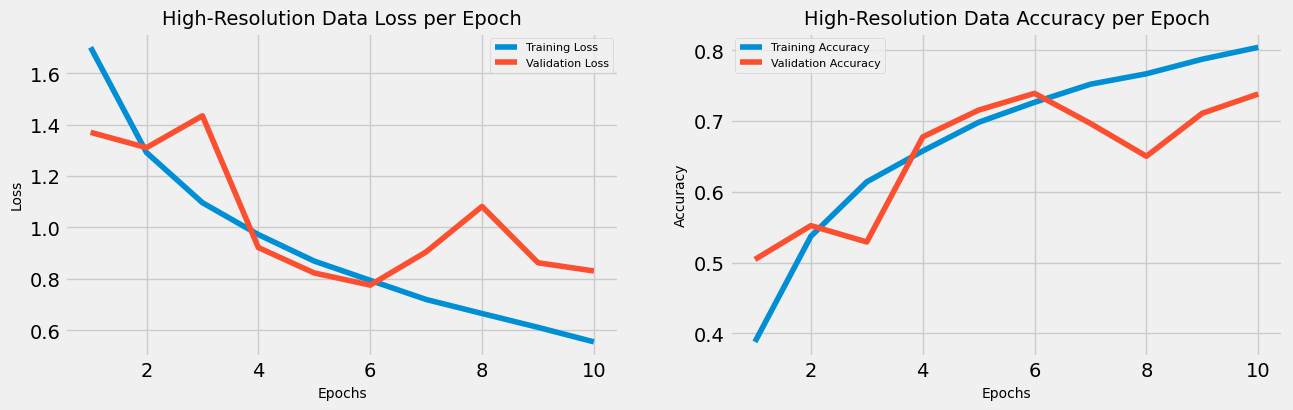

In [13]:
plot_metrics(history_high, "High-Resolution Data")

low resolution

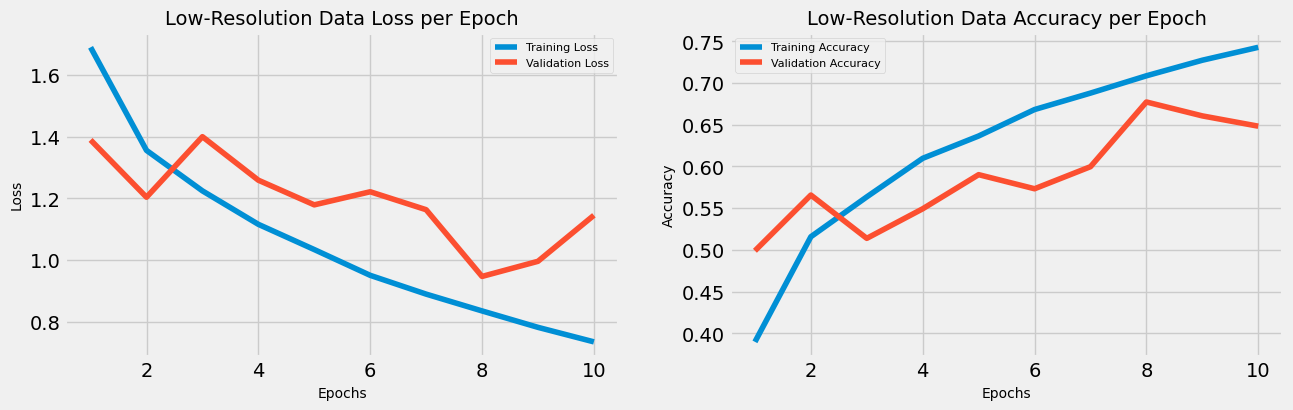

In [14]:
plot_metrics(history_low, "Low-Resolution Data")

# Step 8

confusion matrix

high resolution

In [18]:
y_pred_high= np.argmax(high_res_cnn_model.predict(x_test_high), axis= 1)
conf_matrix_high= confusion_matrix(y_test, y_pred_high)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


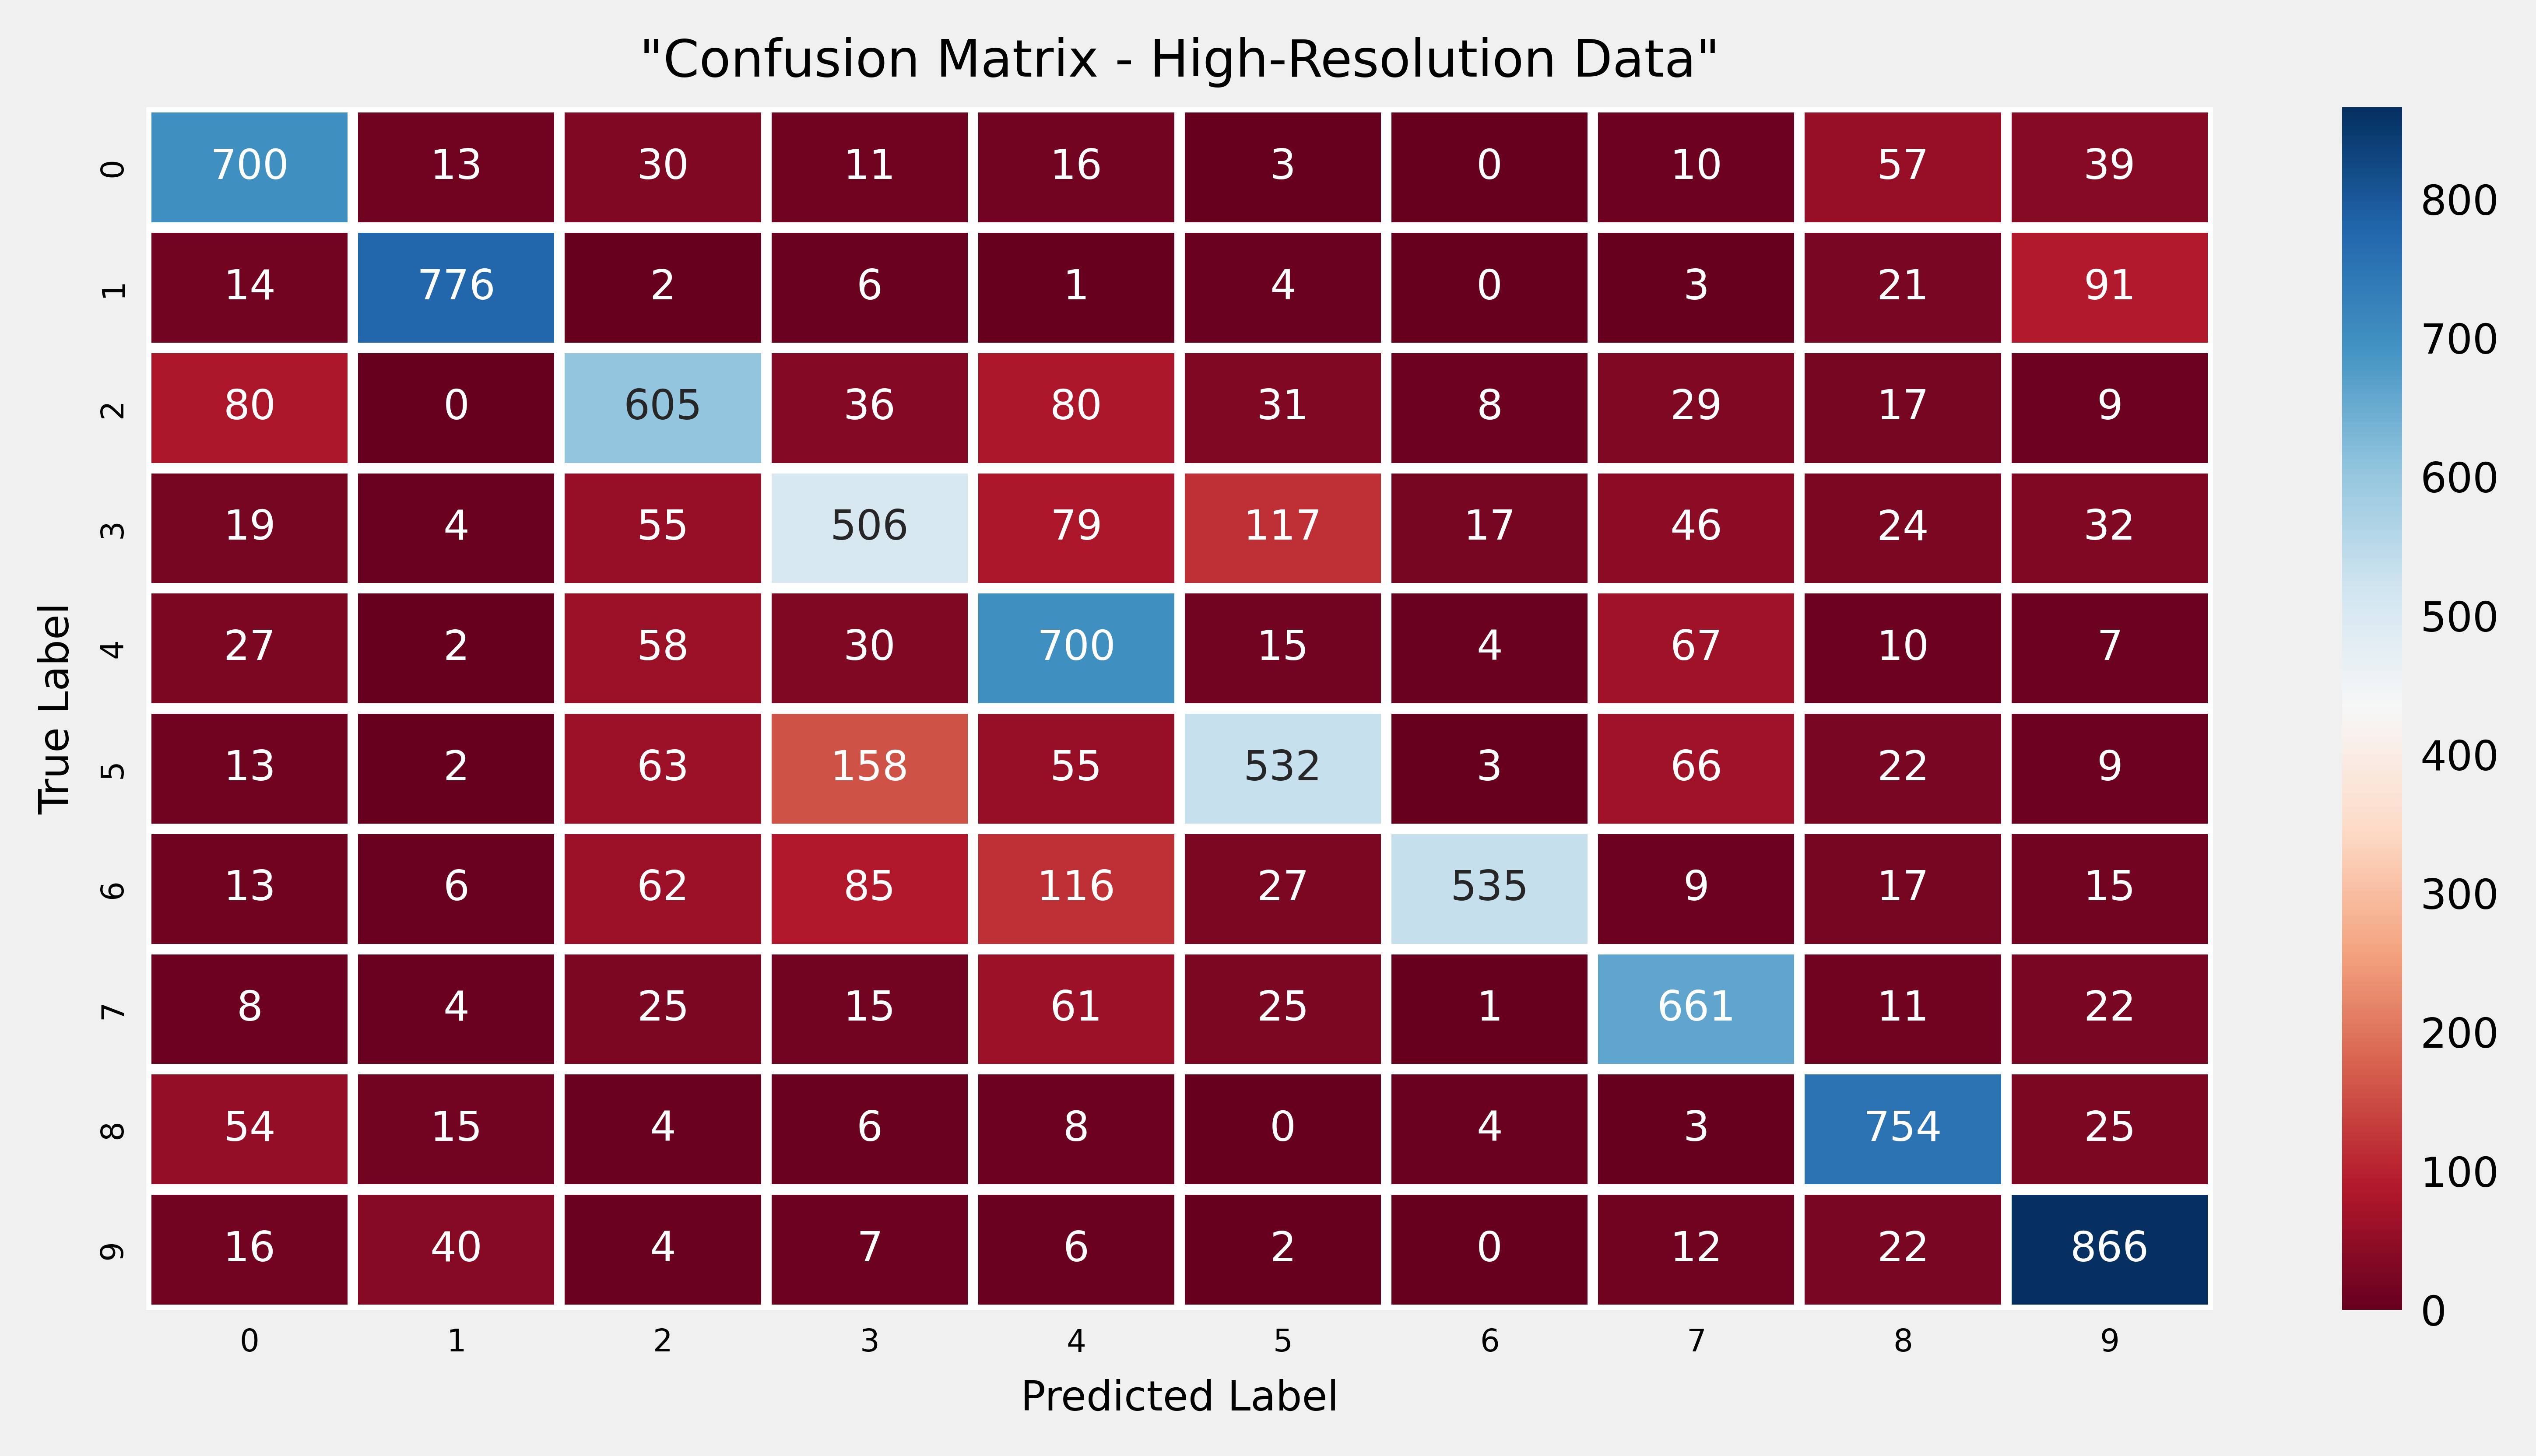

In [19]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_high, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - High-Resolution Data"', fontsize= 10);

low resolution

In [20]:
y_pred_low= np.argmax(low_res_cnn_model.predict(x_test_low), axis=1)
conf_matrix_low= confusion_matrix(y_test, y_pred_low)

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


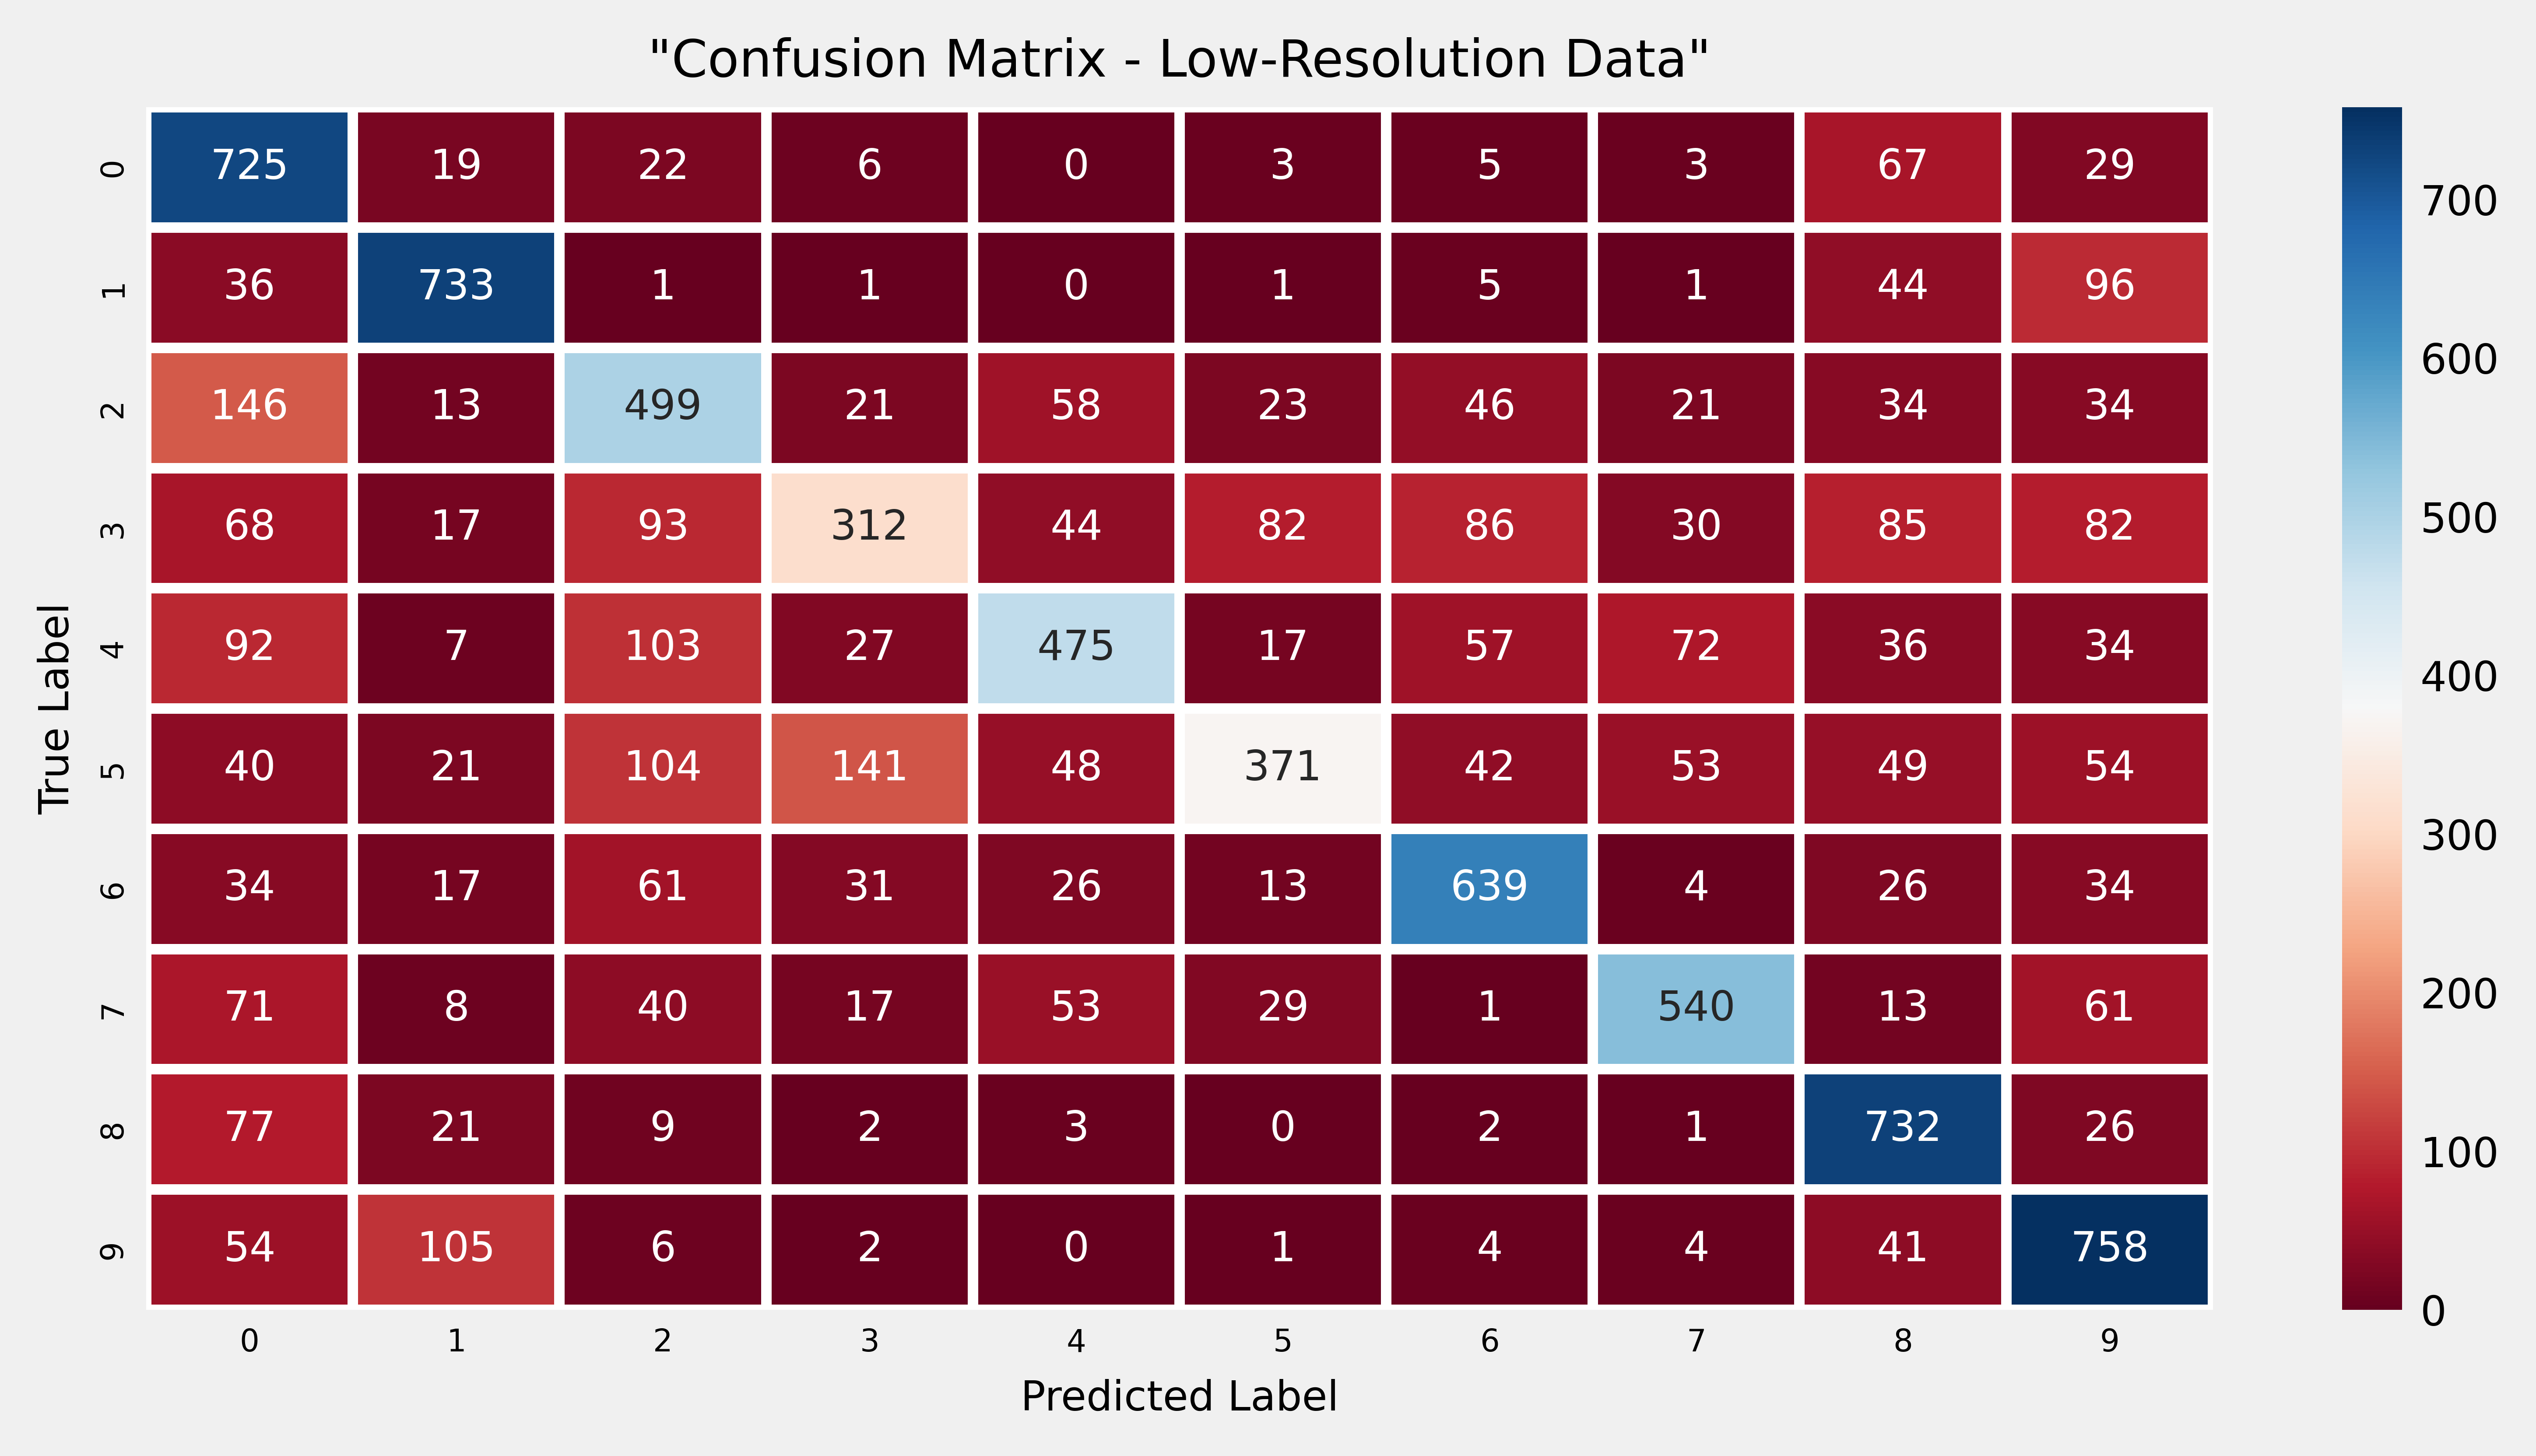

In [21]:
plt.style.use('fivethirtyeight')
fig, ax= plt.subplots(figsize= (8, 4), dpi= 848)
heatmap= sns.heatmap(conf_matrix_low, annot= True, annot_kws={"fontsize": 8}, fmt= 'd', linecolor= 'white', linewidths= 2, cmap= 'RdBu')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize= 8)
ax.set_yticklabels(range(10), fontsize= 6)
ax.set_xticklabels(range(10), fontsize= 6, rotation= 0)
ax.set_xlabel("Predicted Label", fontsize= 8)
ax.set_ylabel("True Label", fontsize= 8)
ax.set_title('"Confusion Matrix - Low-Resolution Data"', fontsize= 10);


# Step 9

accuracy, precision, f1

a

In [23]:
y_pred_high_on_high= np.argmax(high_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_high_on_high= accuracy_score(y_test, y_pred_high_on_high)
precision_high_on_high= precision_score(y_test, y_pred_high_on_high, average= 'weighted')
f1_high_on_high= f1_score(y_test, y_pred_high_on_high, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


b

In [24]:
y_pred_high_on_low= np.argmax(high_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_high_on_low= accuracy_score(y_test, y_pred_high_on_low)
precision_high_on_low= precision_score(y_test, y_pred_high_on_low, average= 'weighted')
f1_high_on_low= f1_score(y_test, y_pred_high_on_low, average= 'weighted')

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/flatten_1/Reshape defined at (most recent call last):
  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "f:\Quera\Qvenv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "f:\Quera\Qvenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_22432\1305353482.py", line 1, in <module>

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 559, in predict

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 256, in one_step_on_data_distributed

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 246, in one_step_on_data

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 101, in predict_step

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\functional.py", line 632, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\numpy.py", line 4761, in reshape

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1885, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/flatten_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_214364]

c

In [25]:
y_pred_low_on_high= np.argmax(low_res_cnn_model.predict(x_test_high), axis= 1)
accuracy_low_on_high= accuracy_score(y_test, y_pred_low_on_high)
precision_low_on_high= precision_score(y_test, y_pred_low_on_high, average= 'weighted')
f1_low_on_high= f1_score(y_test, y_pred_low_on_high, average= 'weighted')

InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/flatten_1_1/Reshape defined at (most recent call last):
  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "f:\Quera\Qvenv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "f:\Quera\Qvenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once

  File "C:\Users\Erfaan_Joodi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "f:\Quera\Qvenv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "f:\Quera\Qvenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_22432\2656208619.py", line 1, in <module>

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 559, in predict

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 256, in one_step_on_data_distributed

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 246, in one_step_on_data

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 101, in predict_step

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\models\functional.py", line 632, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\ops\numpy.py", line 4761, in reshape

  File "f:\Quera\Qvenv\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1885, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1_1/flatten_1_1/Reshape}}]] [Op:__inference_one_step_on_data_distributed_214516]

d

In [26]:
y_pred_low_on_low= np.argmax(low_res_cnn_model.predict(x_test_low), axis= 1)
accuracy_low_on_low= accuracy_score(y_test, y_pred_low_on_low)
precision_low_on_low= precision_score(y_test, y_pred_low_on_low, average= 'weighted')
f1_low_on_low= f1_score(y_test, y_pred_low_on_low, average= 'weighted')

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


results

In [27]:
results= {
    "High model on High test" : (accuracy_high_on_high, precision_high_on_high, f1_high_on_high),
    # "High model on Low test" : (accuracy_high_on_low, precision_high_on_low, f1_high_on_low),
    # "Low model on High test" : (accuracy_low_on_high, precision_low_on_high, f1_low_on_high),
    "Low model on Low test" : (accuracy_low_on_low, precision_low_on_low, f1_low_on_low)
}

for scenario, metrics in results.items():
    print(f"{scenario}:")
    print(f"  Accuracy: {metrics[0]:.4f}")
    print(f"  Precision: {metrics[1]:.4f}")
    print(f"  F1-Score: {metrics[2]:.4f}\n")

High model on High test:
  Accuracy: 0.7372
  Precision: 0.7454
  F1-Score: 0.7356

Low model on Low test:
  Accuracy: 0.6427
  Precision: 0.6486
  F1-Score: 0.6330

